# Customer Analytics for a Telecom Provider

## Importing Libraries

In [1]:
# pip install -r requirements.txt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Loading & Reading Dataset

In [4]:
df = pd.read_csv("dataset/telecom_customer_data.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,CUST00001,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,No
1,CUST00002,Female,0,No,No,35,Yes,No,No,Yes,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,No
2,CUST00003,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,Yes,Yes,Month-to-month,No,Bank transfer (automatic),79.78,No
3,CUST00004,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,Yes
4,CUST00005,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,Yes


#### Info about data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5000 non-null   object 
 1   gender            5000 non-null   object 
 2   SeniorCitizen     5000 non-null   int64  
 3   Partner           5000 non-null   object 
 4   Dependents        5000 non-null   object 
 5   tenure            5000 non-null   int64  
 6   PhoneService      5000 non-null   object 
 7   MultipleLines     5000 non-null   object 
 8   InternetService   5000 non-null   object 
 9   OnlineSecurity    5000 non-null   object 
 10  OnlineBackup      5000 non-null   object 
 11  DeviceProtection  5000 non-null   object 
 12  TechSupport       5000 non-null   object 
 13  StreamingTV       5000 non-null   object 
 14  StreamingMovies   5000 non-null   object 
 15  Contract          5000 non-null   object 
 16  PaperlessBilling  5000 non-null   object 


#### Descriptive Statistics of data

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,5000.0,0.498200,0.500047,0.0,0.0000,0.000,1.000,1.0
tenure,5000.0,35.828400,20.994340,0.0,17.7500,36.000,54.000,72.0
MonthlyCharges,5000.0,70.229976,27.907778,18.0,49.4375,70.185,90.895,120.0


In [7]:
df.describe(include=['object']).T

,count,unique,top,freq
customerID,5000,5000,CUST05000,1
gender,5000,2,Male,2504
Partner,5000,2,Yes,2508
Dependents,5000,2,No,2501
PhoneService,5000,2,No,2542
MultipleLines,5000,3,No phone service,1712
InternetService,5000,3,DSL,1782
OnlineSecurity,5000,3,No internet service,1740
OnlineBackup,5000,3,No,1690
DeviceProtection,5000,3,No,1755


In [8]:
df['Churn'].value_counts()

Churn
No     3652
Yes    1348
Name: count, dtype: int64

so, here data is imbalanced

In [9]:
df1 = df.copy()

## Data Cleaning

#### Dropping unnecessary column

In [10]:
df1.drop('customerID', axis=1, inplace=True, errors='ignore')

#### Finding Duplicates

In [11]:
df1.duplicated().any()

np.False_

**So, here are no duplicate entries.**

#### Finding Missing Values

In [12]:
# Remove leading/trailing whitespaces from all object columns.
# This helps detect hidden missing values like '   ' or 'NaN ' (with spaces), which are strings and not recognized as actual NaN by pandas.
for column in df1.select_dtypes(include=['object']).columns:
    df1[column] = df1[column].str.strip()

In [13]:
# checking missing values 
df1.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
Churn               0
dtype: int64

**So, Here no missing values present.**

#### Identify Categorical and Numerical Features (Excluding Target)

In [14]:
target_col = ['Churn']
numerical_cols = []
categorical_cols = []

separate_cat_num_cols = [categorical_cols.append(col) if df1[col].dtype == 'object' else numerical_cols.append(col) for col in df1.columns if col not in target_col]

In [15]:
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [16]:
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Finding Outliers

#### Finding outliers using boxplot in numerical columns

using seaborn

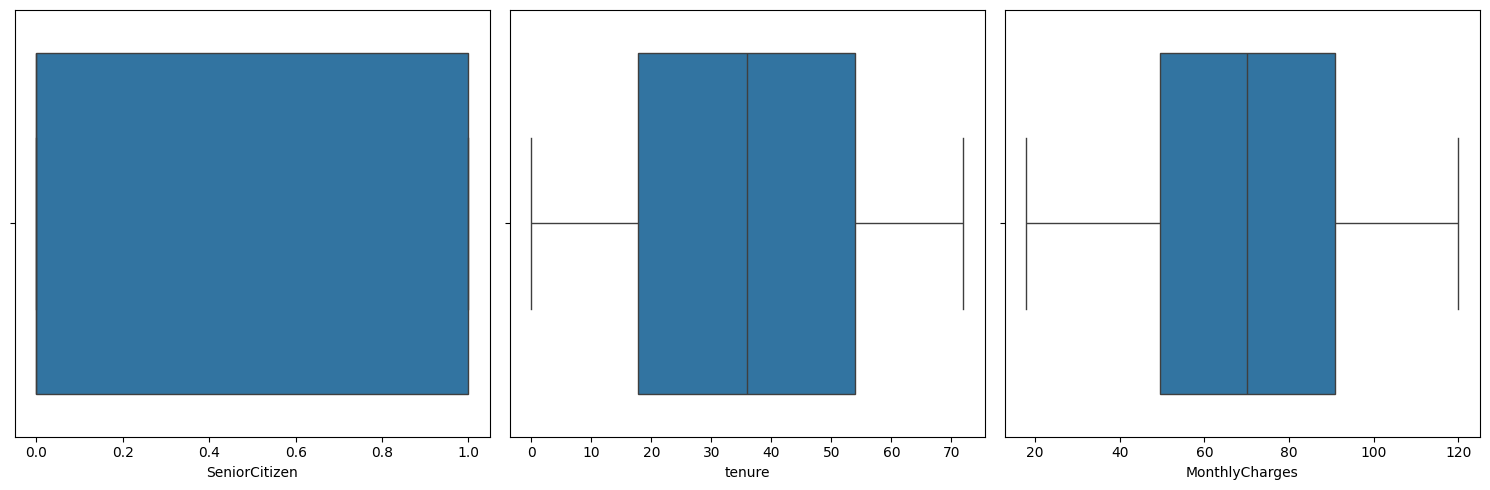

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, column in enumerate(numerical_cols):
    sns.boxplot(data=df1, x=column, ax=axes[i])
    
plt.tight_layout()
plt.show()

So, Here no outliers in numerical columns.

### Fix Data Inconsistencies

#### Correcting Inconsistent 'MultipleLines' Values Based on 'PhoneService'

In [18]:
df1['Inconsistent_multiplelines'] = ((df1['PhoneService'] == "No") & (df1['MultipleLines'] == "Yes"))
df1['Inconsistent_multiplelines'].value_counts()

Inconsistent_multiplelines
False    4155
True      845
Name: count, dtype: int64

If a customer does not have **'PhoneService'**, then they cannot have **'MultipleLines'**.

So according to value counts of 'Inconsistent_multiplelines' 845 entries contains wrong data.

In [19]:
# Replace 'Yes' with 'No phone service' where PhoneService is 'No'
df1.loc[(df1['PhoneService'] == 'No') & (df1['MultipleLines'] == 'Yes'), 'MultipleLines'] = 'No phone service'

In [20]:
# drop 'Inconsistent_multiplelines' column 
df1.drop('Inconsistent_multiplelines', axis=1, inplace=True)

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5000 non-null   object 
 1   SeniorCitizen     5000 non-null   int64  
 2   Partner           5000 non-null   object 
 3   Dependents        5000 non-null   object 
 4   tenure            5000 non-null   int64  
 5   PhoneService      5000 non-null   object 
 6   MultipleLines     5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   OnlineSecurity    5000 non-null   object 
 9   OnlineBackup      5000 non-null   object 
 10  DeviceProtection  5000 non-null   object 
 11  TechSupport       5000 non-null   object 
 12  StreamingTV       5000 non-null   object 
 13  StreamingMovies   5000 non-null   object 
 14  Contract          5000 non-null   object 
 15  PaperlessBilling  5000 non-null   object 
 16  PaymentMethod     5000 non-null   object 


#### Identifying Invalid 'Yes' Values for Internet-Dependent Services 

In [22]:
# Columns that depend on InternetService
internet_dependent_cols = ['OnlineSecurity', 'OnlineBackup', 'StreamingTV', 'StreamingMovies']

In [23]:
# Count 'Yes' values in those columns where InternetService is 'No' (invalid data)
total_records_to_update = 0
print("Records with invalid 'Yes' values when InternetService is 'No':\n")

for col in internet_dependent_cols:
    invalid_count = df1.loc[(df1['InternetService'] == 'No') & (df1[col] == 'Yes')].shape[0]
    print(f"- {invalid_count} records in column '{col}' need to be updated.")
    total_records_to_update += invalid_count

# Count records where all 4 columns have 'Yes' and InternetService is 'No' (common wrong data)
all_cols_invalid = df1.loc[
    (df1['InternetService'] == 'No') &
    (df1['OnlineSecurity'] == 'Yes') &
    (df1['OnlineBackup'] == 'Yes') &
    (df1['StreamingTV'] == 'Yes') &
    (df1['StreamingMovies'] == 'Yes')
].shape[0]

print(f"\n {all_cols_invalid} records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.")
print(f"\n Total individual updates to be made: {total_records_to_update}\n")

Records with invalid 'Yes' values when InternetService is 'No':

- 550 records in column 'OnlineSecurity' need to be updated.
- 538 records in column 'OnlineBackup' need to be updated.
- 540 records in column 'StreamingTV' need to be updated.
- 528 records in column 'StreamingMovies' need to be updated.

 23 records have 'Yes' in **all** internet-dependent columns despite InternetService being 'No'.

 Total individual updates to be made: 2156



####  Replacing Invalid 'Yes' Values with 'No internet service'

In [24]:
# Perform the updates
updated_record_count = 0
for col in internet_dependent_cols:
    mask = (df1['InternetService'] == 'No') & (df1[col] == 'Yes')
    updated_record_count += mask.sum()
    df1.loc[mask, col] = 'No internet service'

print(f"Total records successfully updated: {updated_record_count}")

Total records successfully updated: 2156


## EDA - Exploratory Data Analysis

### Label Encoding on Target Variable for EDA

In [25]:
# label encoding on target variable
le = LabelEncoder()
df1["Churn"] = le.fit_transform(df1["Churn"])

In [26]:
df1[['Churn']].head()

,Churn
0,0
1,0
2,0
3,1
4,1


### Correlation of Numerical Features 

In [27]:
corr_matrix = df1[numerical_cols].corr()

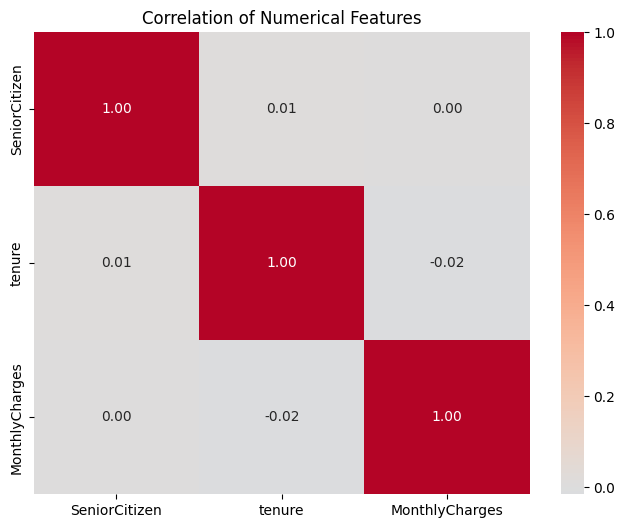

In [28]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title("Correlation of Numerical Features")
plt.show()

### Countplot of Categorical columns to see imbalance data

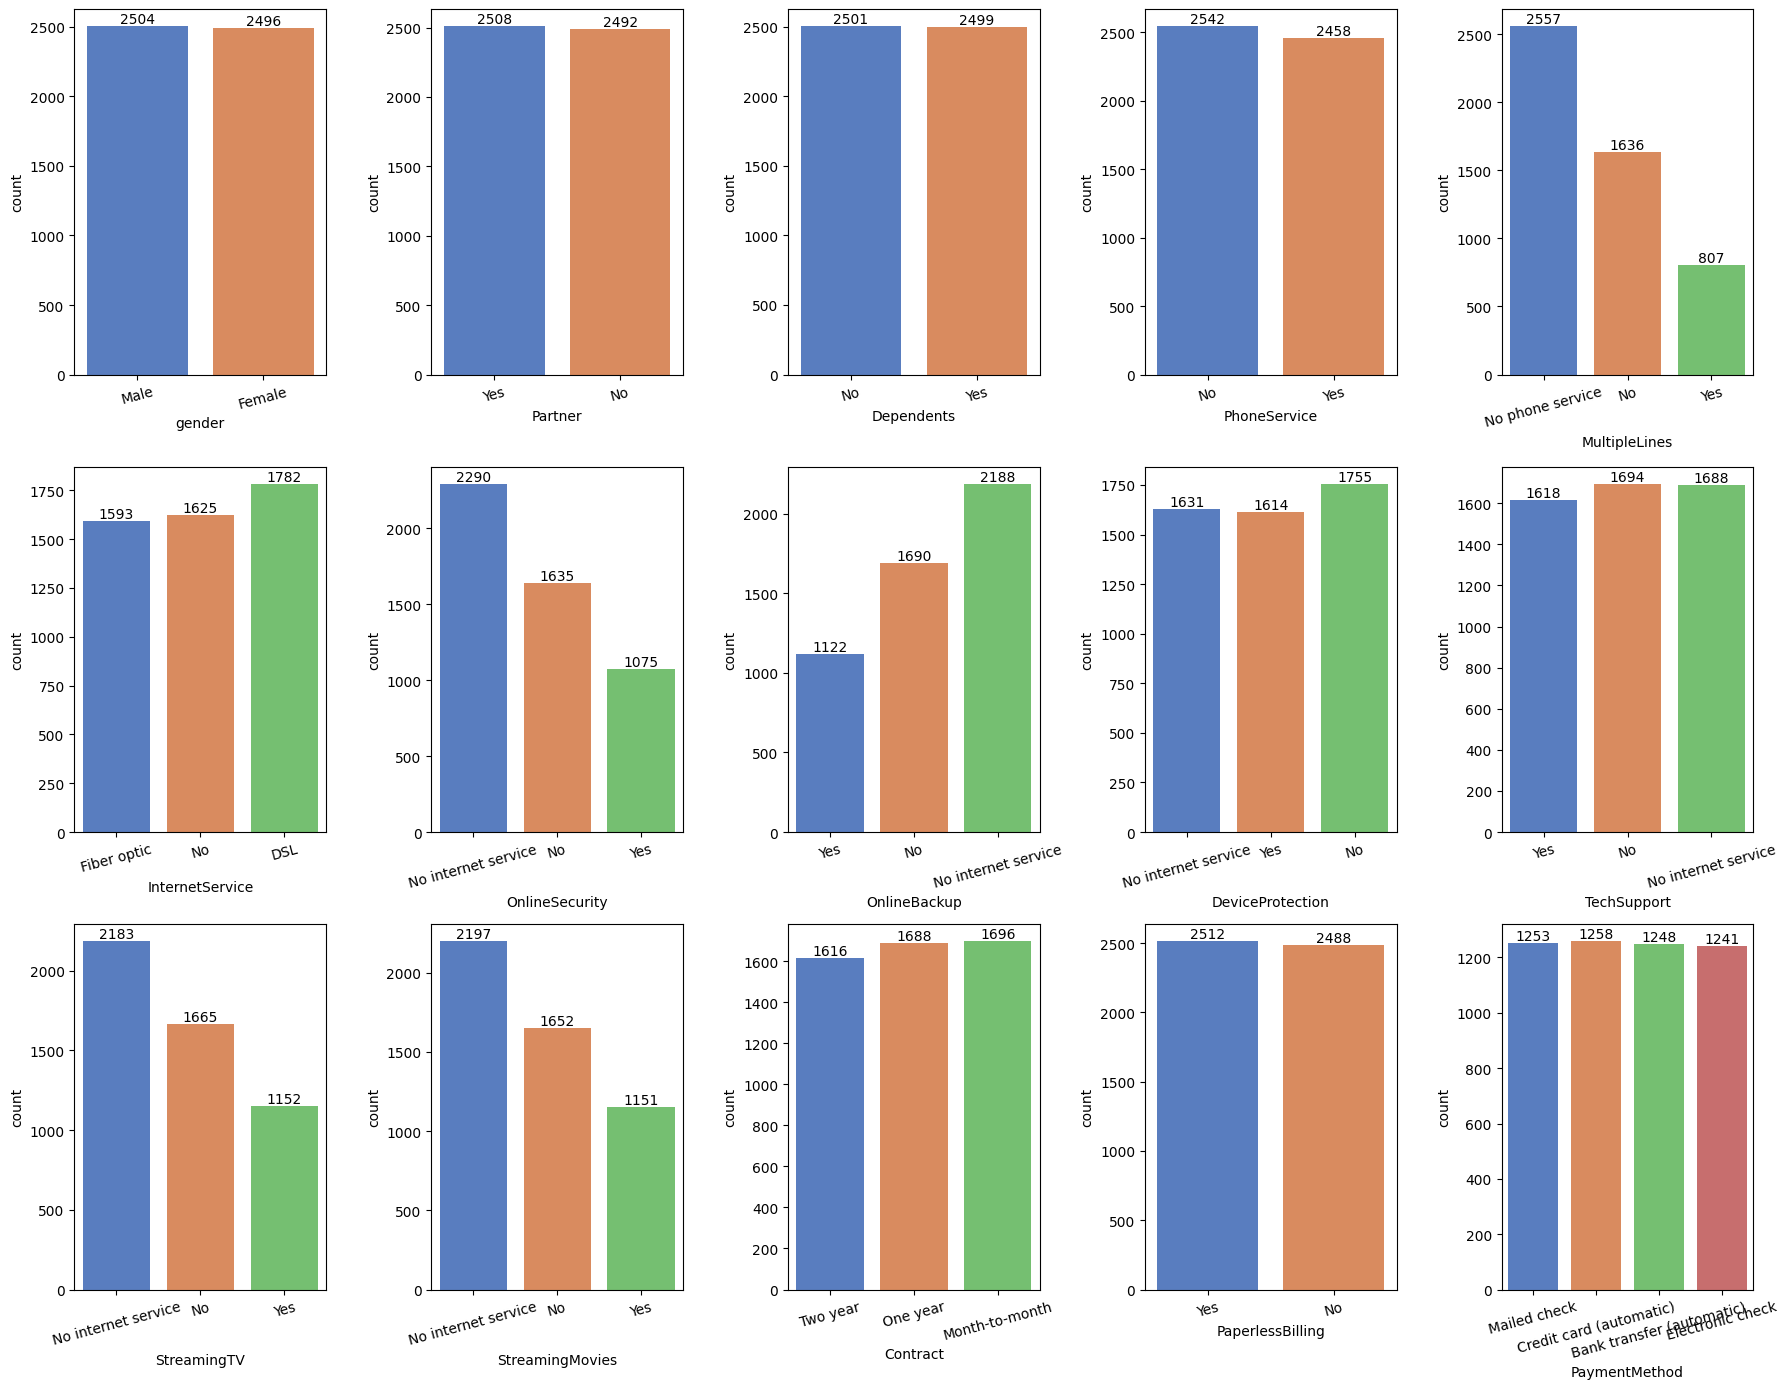

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 14))

for ax, column in zip(axes.flatten(), categorical_cols):
    sns_fig = sns.countplot(data=df1, ax=ax, x=column, hue=column, palette='muted')
    sns_fig.tick_params(axis='x', rotation=15)
    for container in sns_fig.containers:
        sns_fig.bar_label(container)

plt.tight_layout()
plt.show()

### Pie Chart of Categorical columns

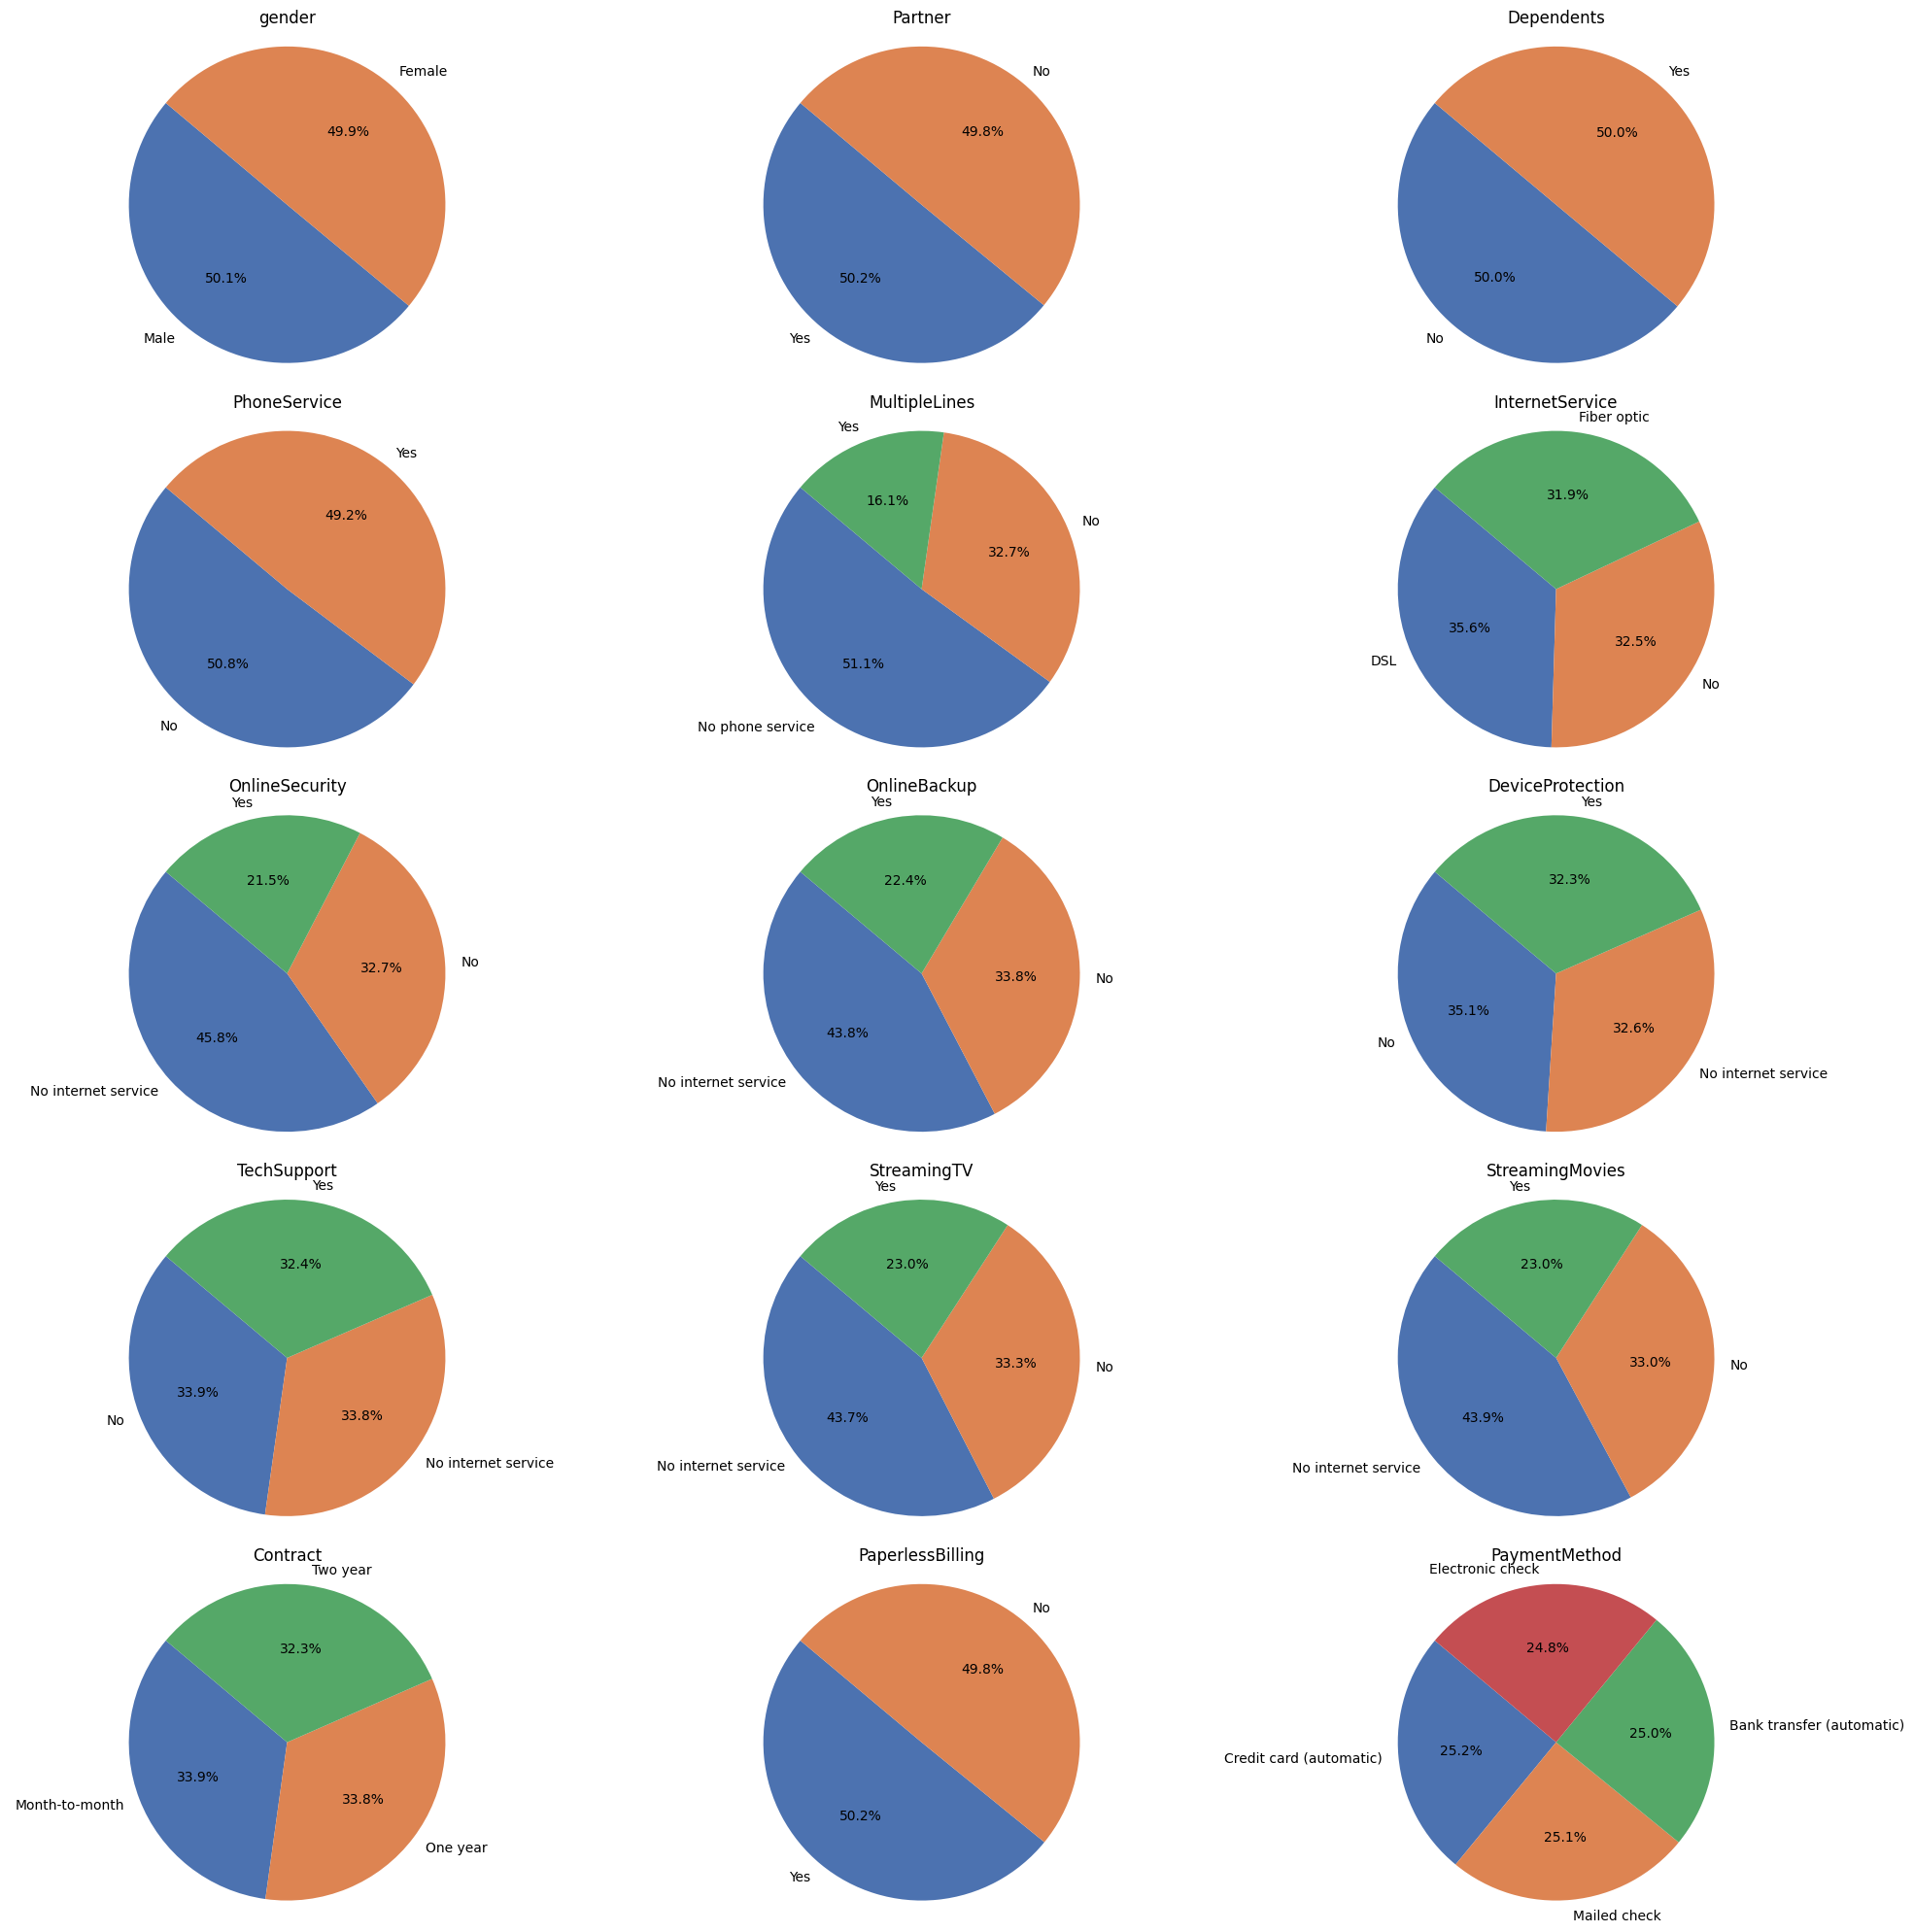

In [30]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
colors = sns.color_palette("deep") 

for ax, col in zip(axes.flatten(), categorical_cols):
    counts = df1[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=colors)
    ax.set_title(col)
    ax.axis('equal')  

plt.tight_layout()
plt.show()

### Pairplot of Numerical features with Churn

Text(0.5, 1.0, 'Pairplot of Numerical features with Churn')

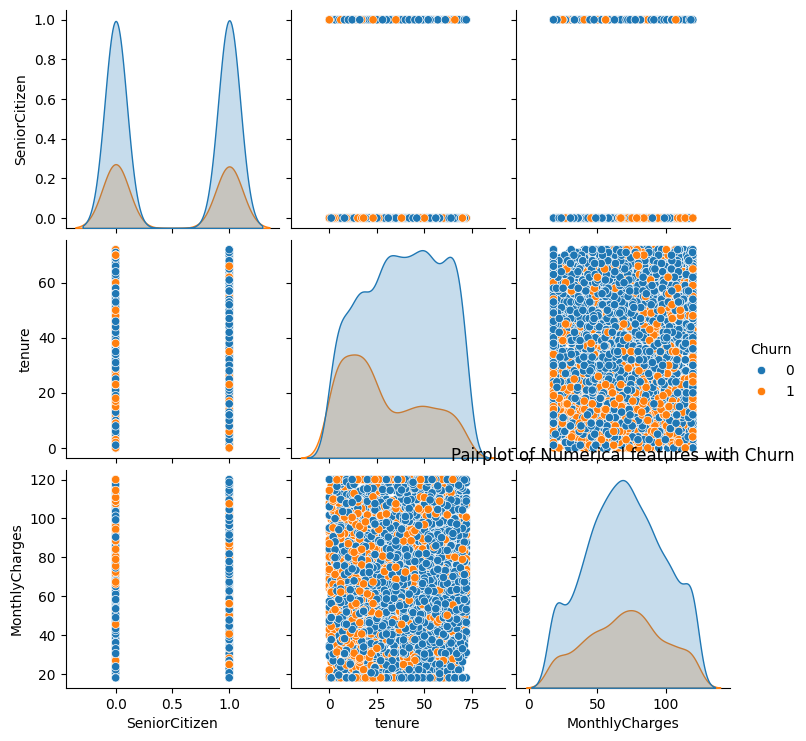

In [31]:
sns.pairplot(df1, vars=numerical_cols[:3], hue='Churn')
plt.title('Pairplot of Numerical features with Churn')

### Tenure distribution vs Churn 

Text(0.5, 1.0, 'Tenure distribution by Churn')

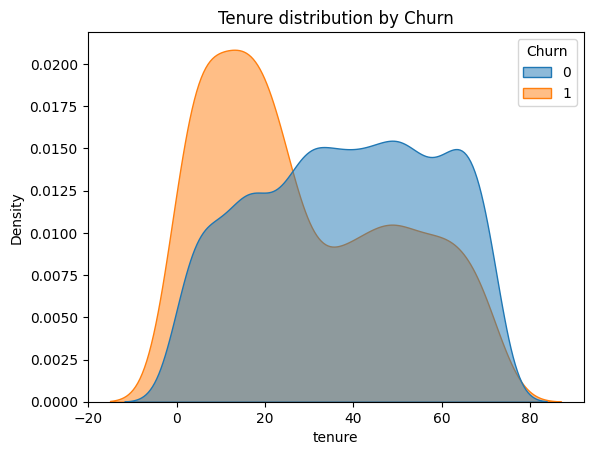

In [32]:
sns.kdeplot(data=df1, x='tenure', hue='Churn', fill=True, common_norm=False, alpha=0.5)
plt.title(f"Tenure distribution by Churn")

- Customers with lower tenure (less than 30 months) or New customers are more likely to churn.

### SeniorCitizen vs Churn

Text(0.5, 1.0, 'Senior Citizen by Churn')

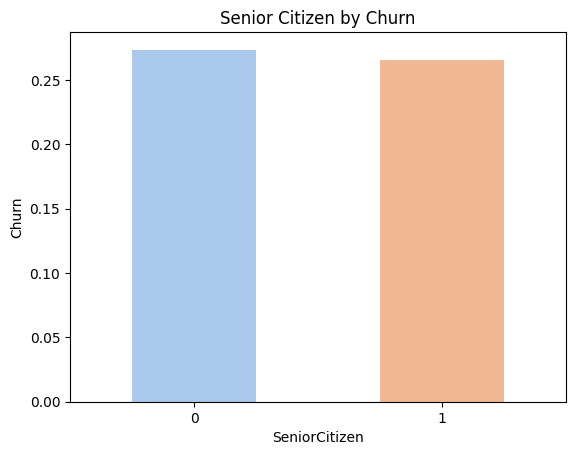

In [33]:
sns.barplot(data=df1, x='SeniorCitizen', y='Churn', ci=None, palette='pastel', width=0.5)
plt.title(f"Senior Citizen by Churn")

- Non SeniorCitizen have high churn rate than SeniorCitizen.

### MonthlyCharges Distribution by Churn

Text(0.5, 1.0, 'Distribution of Monthly Charges by Churn')

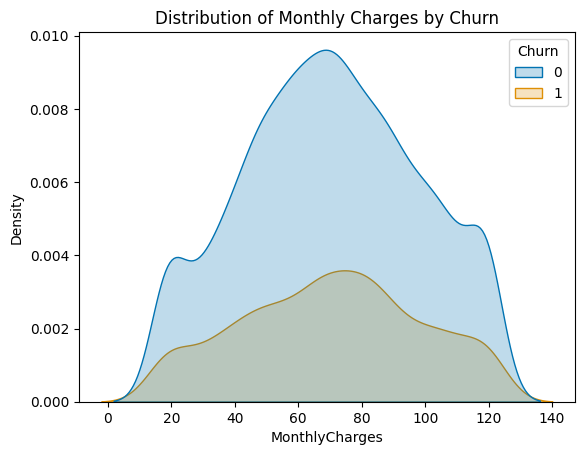

In [34]:
sns.kdeplot(data=df1, x='MonthlyCharges', hue='Churn', fill=True, palette="colorblind")
plt.title("Distribution of Monthly Charges by Churn")

- Customers who churn often have higher monthly charges compared to those who stay.

### MonthlyCharges vs Contract Type with Churn

Text(0.5, 1.0, 'Monthly Charges by Contract Type and Churn Status')

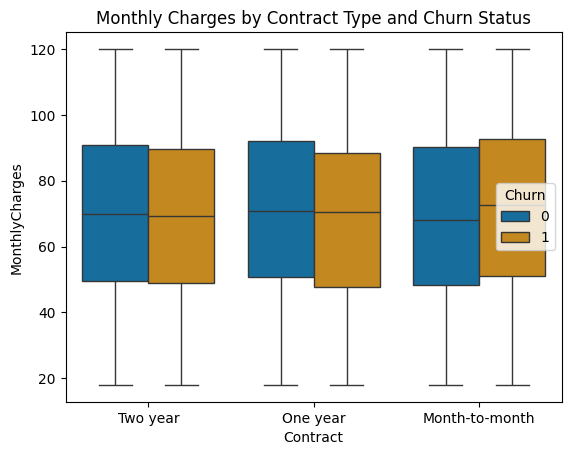

In [35]:
sns.boxplot(data=df1, x='Contract', y='MonthlyCharges', hue='Churn', palette="colorblind")
plt.title("Monthly Charges by Contract Type and Churn Status")

- Month-to-month contracts have higher monthly charges and higher churn rates than longer contracts.

### MonthlyCharges vs. InternetService with Churn

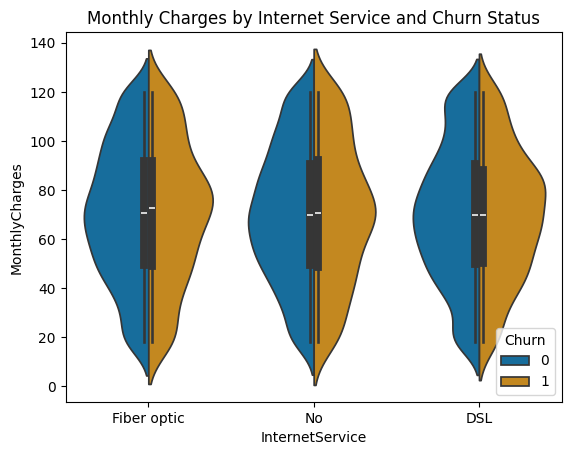

In [36]:
sns.violinplot(data=df1, x='InternetService', y='MonthlyCharges', hue='Churn', split=True, palette="colorblind")
plt.title("Monthly Charges by Internet Service and Churn Status")
plt.show()

- Fiber optic customers have higher monthly charges and are more likely to churn than DSL or no-internet customers.

### Churn Rate by Tenure and MonthlyCharges

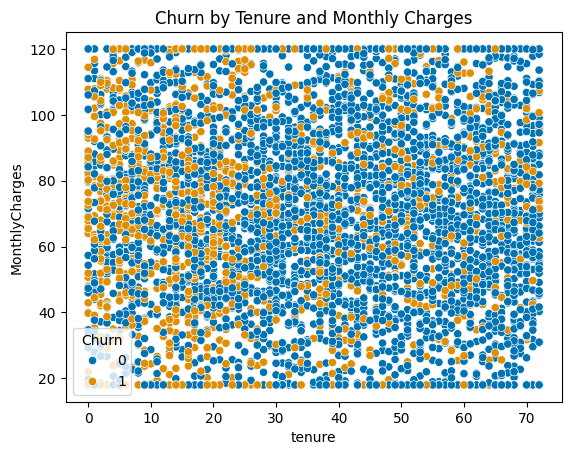

In [37]:
sns.scatterplot(data=df1, x='tenure', y='MonthlyCharges', hue='Churn', palette="colorblind")
plt.title("Churn by Tenure and Monthly Charges")
plt.show()

- Customers with high monthly charges and low tenure are more likely to churn.

### Churn Rate by Partner Status and Contract Type

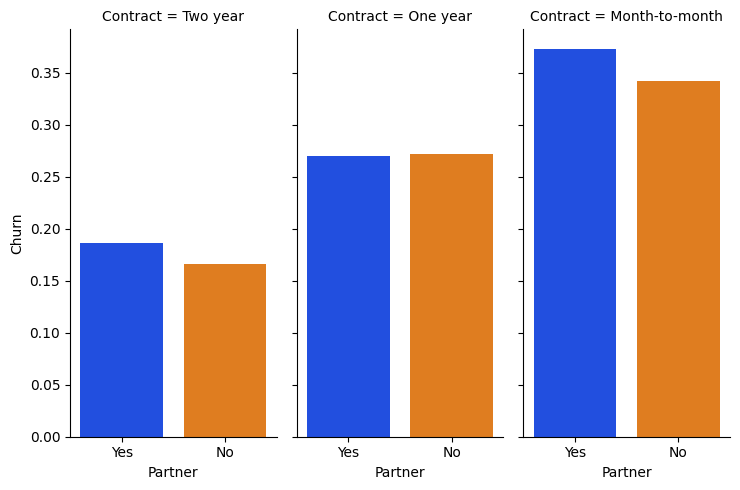

In [38]:
sns.catplot(data=df1, x='Partner', y='Churn', col='Contract', kind='bar', ci=None, palette="bright", estimator='mean', aspect=.5)

- Customers on a Month-to-Month contract churn the most, especially those without a partner.
- Churn is lowest for Two-year contracts

### Churn Rate by Dependent Status and Contract Type

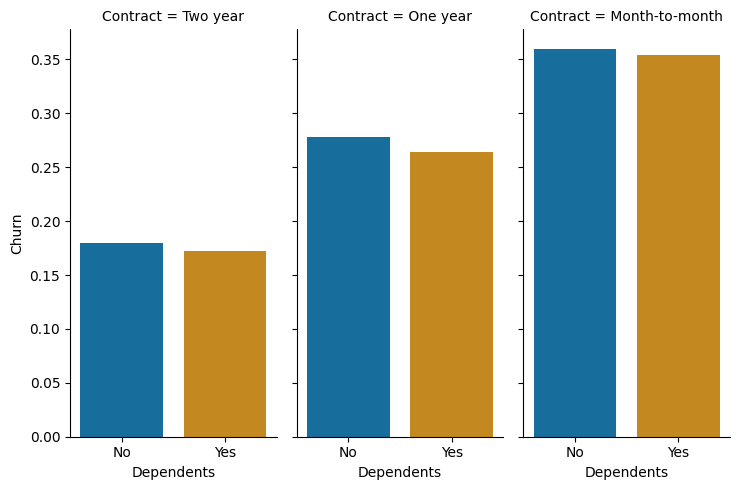

In [39]:
sns.catplot(data=df1, x='Dependents', y='Churn', col='Contract', kind='bar', ci=None, palette="colorblind", aspect=.5)

- Customers with no dependents are more likely to churn across all contract types.

### Churn Rate by Internet and Phone Service

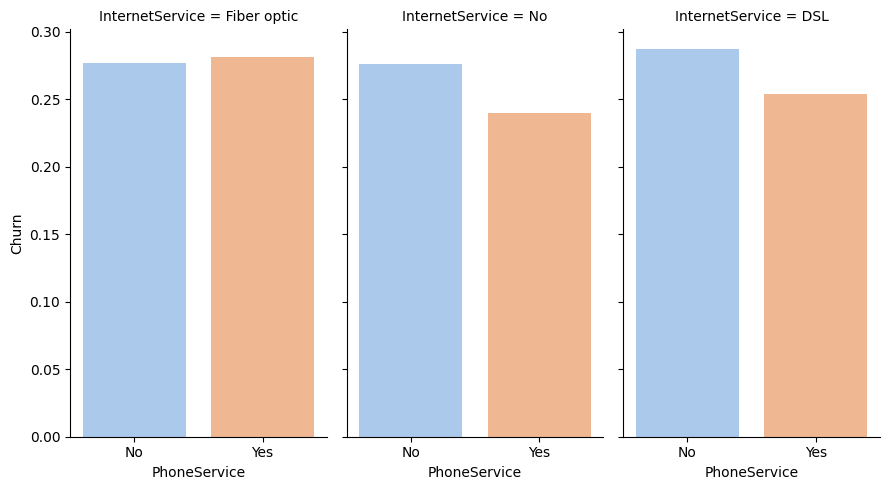

In [40]:
sns.catplot(data=df1, col='InternetService', y='Churn', x='PhoneService', kind='bar', ci=None, palette='pastel', aspect=.6)

- Customers with DSL internet service have a significantly higher churn rate.
- Csutomers with PhoneService and No InternetService have lowest churn rate.

### Churn Rate by Tech Support and Device Protection

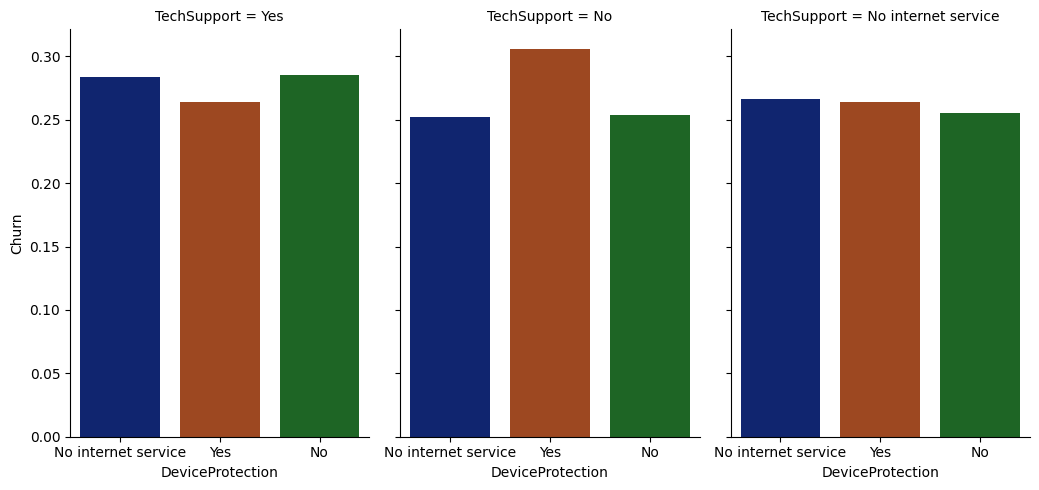

In [41]:
sns.catplot(data=df1, x='DeviceProtection', y='Churn', col='TechSupport', kind='bar', ci=None, palette="dark", aspect=.7)

- Churn is highest when TechSupport is 'No', especially for customers who also have Device Protection.

### StreamingTV * StreamingMovies vs Churn

<Axes: xlabel='StreamingMovies', ylabel='StreamingTV'>

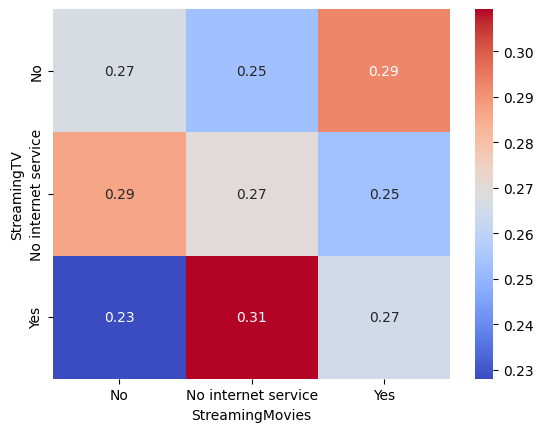

In [42]:
pivot = df1.pivot_table(values='Churn', index='StreamingTV', columns='StreamingMovies')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

- Churn is slightly higher (0.31) when StreamingTV is Yes and StreamingMovies is listed as 'No internet service'.

### Contract * Internet Service vs Churn

<Axes: xlabel='InternetService', ylabel='Contract'>

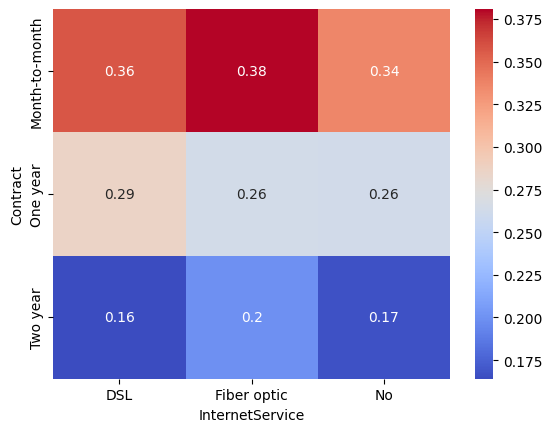

In [43]:
pivot = df1.pivot_table(values='Churn', index='Contract', columns='InternetService')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

- Churn is highest for Month-to-month contracts, especially with Fiber optic (38%) and DSL (36%) internet.
- Two-year contracts show the lowest churn across all internet types, indicating long-term contracts improve retention.

### How Service Count Influences Customer Churn

Text(0.5, 1.0, 'TotalServices vs Churn')

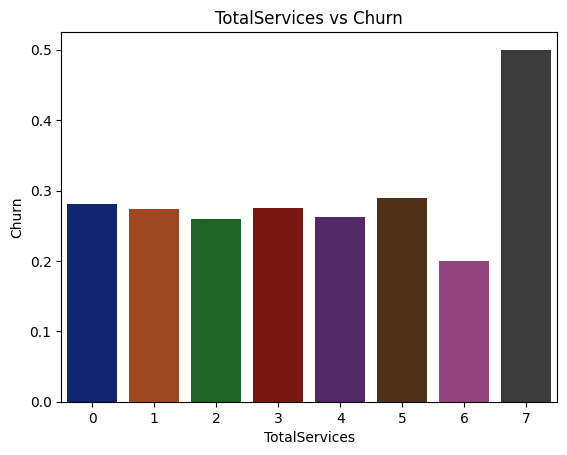

In [44]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PhoneService']
df1['TotalServices'] = df1[services].apply(lambda x: (x == 'Yes').sum(), axis=1)
sns.barplot(data=df1, x='TotalServices', y='Churn', ci=None, palette='dark')
plt.title('TotalServices vs Churn')

- Churn rate is highest (~50%) for users with all 7 services.
- For 0–5 services, churn stays around 27–30% with no clear trend.



### How number of Services Impacts MonthlyCharges

Text(0.5, 1.0, 'TotalServices vs MonthlyCharges')

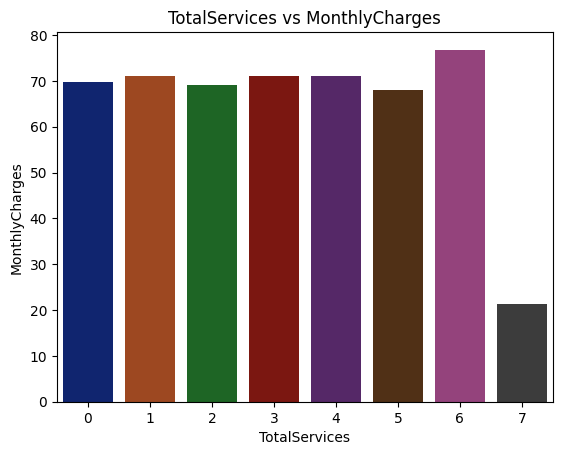

In [45]:
services = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'PhoneService']
df1['TotalServices'] = df1[services].apply(lambda x: (x == 'Yes').sum(), axis=1)
sns.barplot(data=df1, x='TotalServices', y='MonthlyCharges', ci=None, palette='dark')
plt.title('TotalServices vs MonthlyCharges')

- Monthly charges increase with the number of services.
- Charges drop significantly to the lowest at 7 services, suggesting possible discounts for higher service bundles.

### Monthly Charges by PhoneService, InternetService 

Text(0.5, 1.0, 'PhoneService, InternetService vs MonthlyCharges')

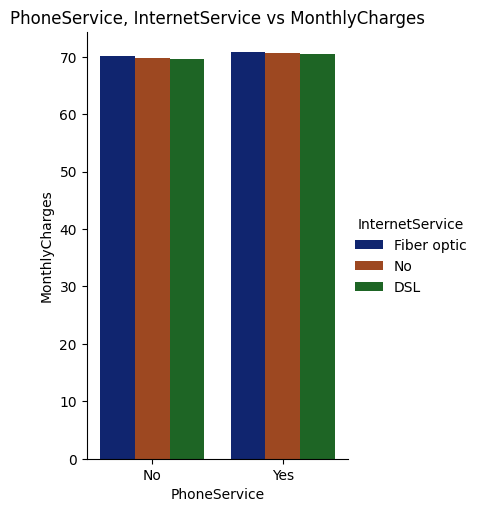

In [46]:
sns.catplot(data=df1, x='PhoneService', y='MonthlyCharges', hue='InternetService', kind='bar', ci=None, palette="dark", aspect=.7)
plt.title('PhoneService, InternetService vs MonthlyCharges')

- Fiber optic service consistently leads to the highest monthly charges.

### Multiplelines vs MonthlyCharges

<Axes: xlabel='MultipleLines', ylabel='MonthlyCharges'>

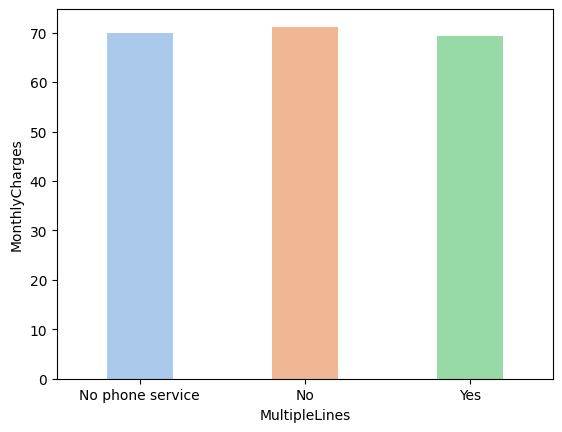

In [47]:
sns.barplot(data=df1, x='MultipleLines', y='MonthlyCharges', width=0.4, ci=None, palette='pastel')

### Contract vs MonthlyCharges

<Axes: xlabel='Contract', ylabel='MonthlyCharges'>

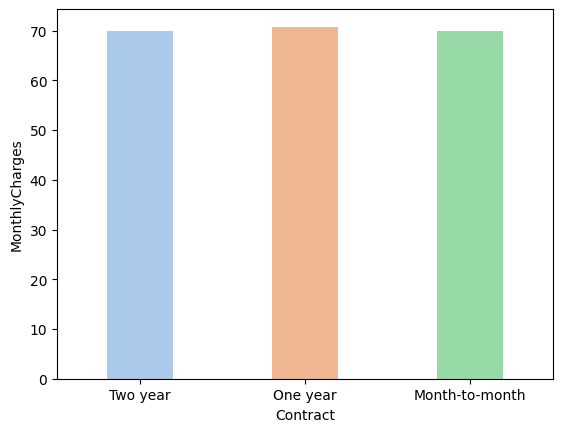

In [48]:
sns.barplot(data=df1, x='Contract', y='MonthlyCharges', width=0.4, ci=None, palette='pastel')

### StreamingTV, StreamingMovies vs MonthlyCharges

<Axes: xlabel='StreamingMovies', ylabel='StreamingTV'>

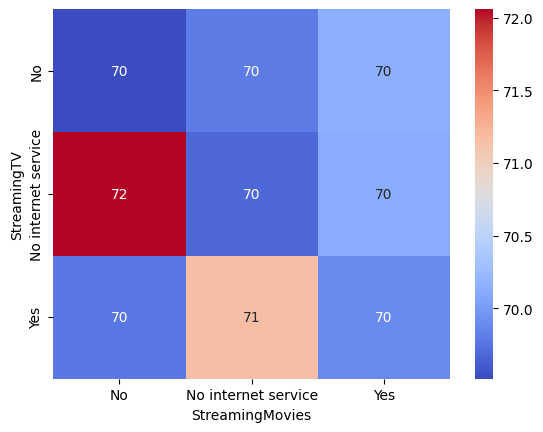

In [49]:
pivot = df1.pivot_table(values='MonthlyCharges', index='StreamingTV', columns='StreamingMovies')
sns.heatmap(pivot, annot=True, cmap='coolwarm')

- Customers without internet service have slightly higher charges.
- StreamingTV + StreamingMovies does not raise charges much.

### MonthlyCharges vs Dependents and Partner with Churn

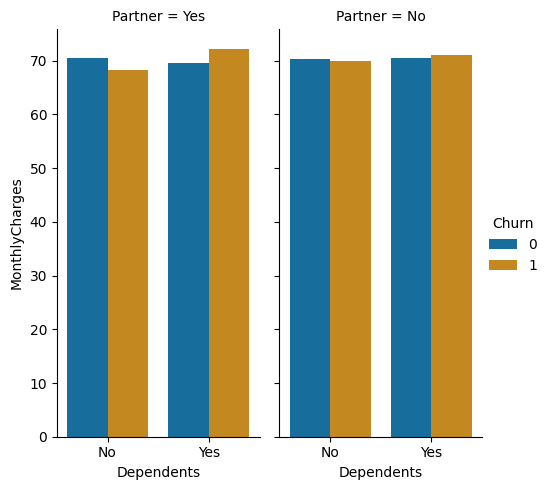

In [50]:
sns.catplot(data=df1, x='Dependents', y='MonthlyCharges', col='Partner', hue='Churn', kind='bar', ci=None, palette="colorblind", aspect=.5)

- Customers without dependents and a partner tend to have higher monthly charges and are more likely to churn.

### PaymentMethod vs Churn

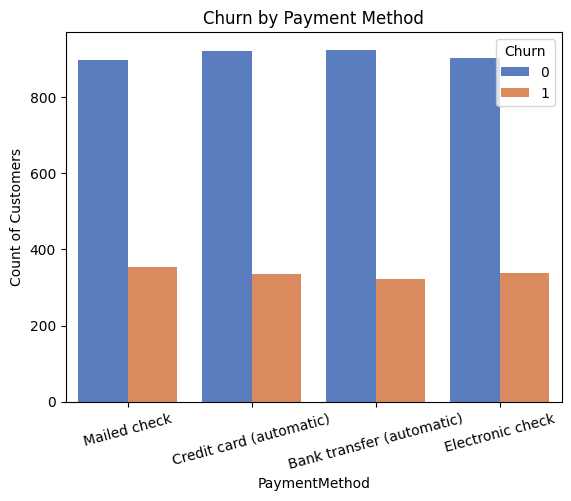

In [51]:
sns.countplot(data=df1, x='PaymentMethod', hue='Churn', palette='muted')
plt.title('Churn by Payment Method')
plt.ylabel('Count of Customers')
plt.xticks(rotation=15)
plt.show()

- Customers using Mailed checks have a higher churn count compared to other payment methods.

In [52]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalServices
0,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,0,2
1,Female,0,No,No,35,Yes,No,No,No internet service,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,0,3
2,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),79.78,0,2
3,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,1,1
4,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,1,2


In [53]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5000 non-null   object 
 1   SeniorCitizen     5000 non-null   int64  
 2   Partner           5000 non-null   object 
 3   Dependents        5000 non-null   object 
 4   tenure            5000 non-null   int64  
 5   PhoneService      5000 non-null   object 
 6   MultipleLines     5000 non-null   object 
 7   InternetService   5000 non-null   object 
 8   OnlineSecurity    5000 non-null   object 
 9   OnlineBackup      5000 non-null   object 
 10  DeviceProtection  5000 non-null   object 
 11  TechSupport       5000 non-null   object 
 12  StreamingTV       5000 non-null   object 
 13  StreamingMovies   5000 non-null   object 
 14  Contract          5000 non-null   object 
 15  PaperlessBilling  5000 non-null   object 
 16  PaymentMethod     5000 non-null   object 


## Encoding

In [54]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalServices
0,Male,0,Yes,No,54,No,No phone service,Fiber optic,No internet service,Yes,No internet service,Yes,No internet service,No internet service,Two year,Yes,Mailed check,96.48,0,2
1,Female,0,No,No,35,Yes,No,No,No internet service,No,Yes,Yes,No,No internet service,One year,No,Credit card (automatic),87.58,0,3
2,Male,0,Yes,No,36,Yes,No phone service,No,No internet service,No internet service,No internet service,Yes,No internet service,No internet service,Month-to-month,No,Bank transfer (automatic),79.78,0,2
3,Male,0,No,Yes,13,No,No phone service,Fiber optic,No,Yes,No,No,No internet service,No internet service,One year,Yes,Bank transfer (automatic),112.28,1,1
4,Male,1,No,Yes,26,Yes,No,Fiber optic,No,Yes,No,No,No internet service,No internet service,Month-to-month,Yes,Mailed check,45.77,1,2


In [55]:
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges']

In [56]:
categorical_cols

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

### Ordinal Encoding

#### Ordinal encoding on 'Contract' as it contains ordered values

In [57]:
contract_order = [['Month-to-month', 'One year', 'Two year']]
ord_encoder = OrdinalEncoder(categories=contract_order)
df1[['Contract']] = ord_encoder.fit_transform(df1[['Contract']])

### Label Encoding

#### Label Encoding on 'gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PaymentMethod' (Contain yes/no values & male/female)

In [58]:
# Columns to encode
label_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'PaymentMethod']

# Apply LabelEncoder to each column
le = LabelEncoder()
for col in label_cols:
    df1[col] = le.fit_transform(df1[col])

#### Label Encoding on InternetService dependent columns where values are: 'Yes', 'No', 'No internet service' / 'No phone service'

In [59]:
# InternetService dependent columns where values are: 'Yes', 'No', 'No internet service' / 'No phone service'
internet_dependent_cols = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# label encoding
for col in internet_dependent_cols:
    encoder = LabelEncoder()
    df1[col] = encoder.fit_transform(df1[col])

### One-hot Encoding

#### One-hot Encoding on 'InternetService'

In [60]:
internet_encoder = OneHotEncoder(drop=None, sparse_output=False, dtype=int)
internet_encoded = internet_encoder.fit_transform(df1[['InternetService']])
internet_encoded_cols = internet_encoder.get_feature_names_out(['InternetService'])
df1[internet_encoded_cols] = internet_encoded
# Drop the original 'InternetService' column
df1.drop('InternetService', axis=1, inplace=True)

In [61]:
df1.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn,TotalServices,InternetService_DSL,InternetService_Fiber optic,InternetService_No
0,1,0,1,0,54,0,1,1,2,1,...,1,2.0,1,3,96.48,0,2,0,1,0
1,0,0,0,0,35,1,0,1,0,2,...,1,1.0,0,1,87.58,0,3,0,0,1
2,1,0,1,0,36,1,1,1,1,1,...,1,0.0,0,0,79.78,0,2,0,0,1
3,1,0,0,1,13,0,1,0,2,0,...,1,1.0,1,0,112.28,1,1,0,1,0
4,1,1,0,1,26,1,0,0,2,0,...,1,0.0,1,3,45.77,1,2,0,1,0


## Correlation

### Correalation Heatmap of all features

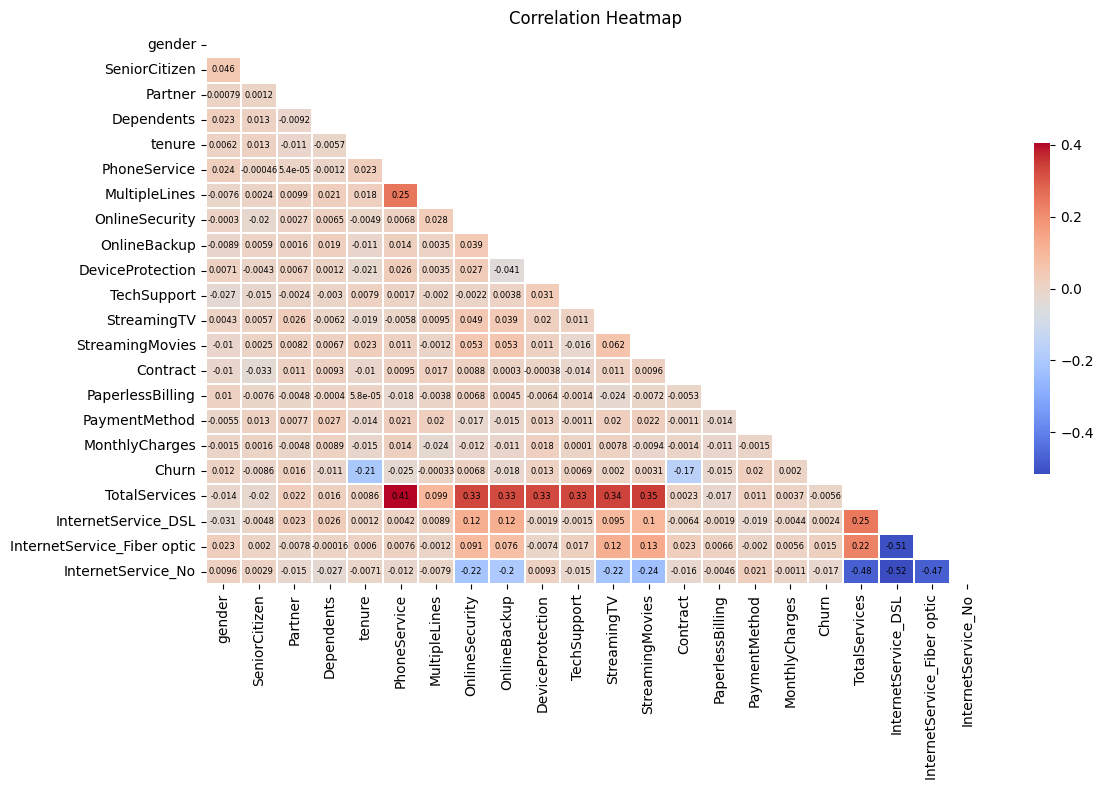

In [62]:
corr = df1.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 8))
plt.title("Correlation Heatmap")
sns.heatmap(corr, mask=mask, cmap="coolwarm", annot=True, linewidths=1.3, cbar_kws={"shrink": 0.6}, annot_kws={"size": 6, "color": 'black'})
plt.tight_layout()
plt.show()

##### Observations (from Heatmap)
- tenure has a strong negative correlation with Churn (≈ -0.21) → longer staying customers churn less.
- Contract type also shows strong negative correlation with Churn (≈ -0.17) → longer contracts = reduced churn.
- InternetService_Fiber optic has a strong positive correlation with Churn (+0.52) → fiber users are more likely to churn.
- InternetService_No has a strong negative correlation with Churn (-0.47) → customers with no internet churn less (likely inactive accounts).
- OnlineSecurity, TechSupport, and StreamingTV have weak negative correlation with Churn (~ -0.2 to -0.25) → suggest churn protection.
- MonthlyCharges has very low correlation with Churn (~0.02) → cost alone doesn't strongly affect churn.
- Features like Partner, gender, and PaymentMethod have near-zero correlation → likely not useful individually.
- MultipleLines has a positive correlation with Churn (+0.25) → customers with multiple lines may churn more.

### Correlation plot of all features vs Churn

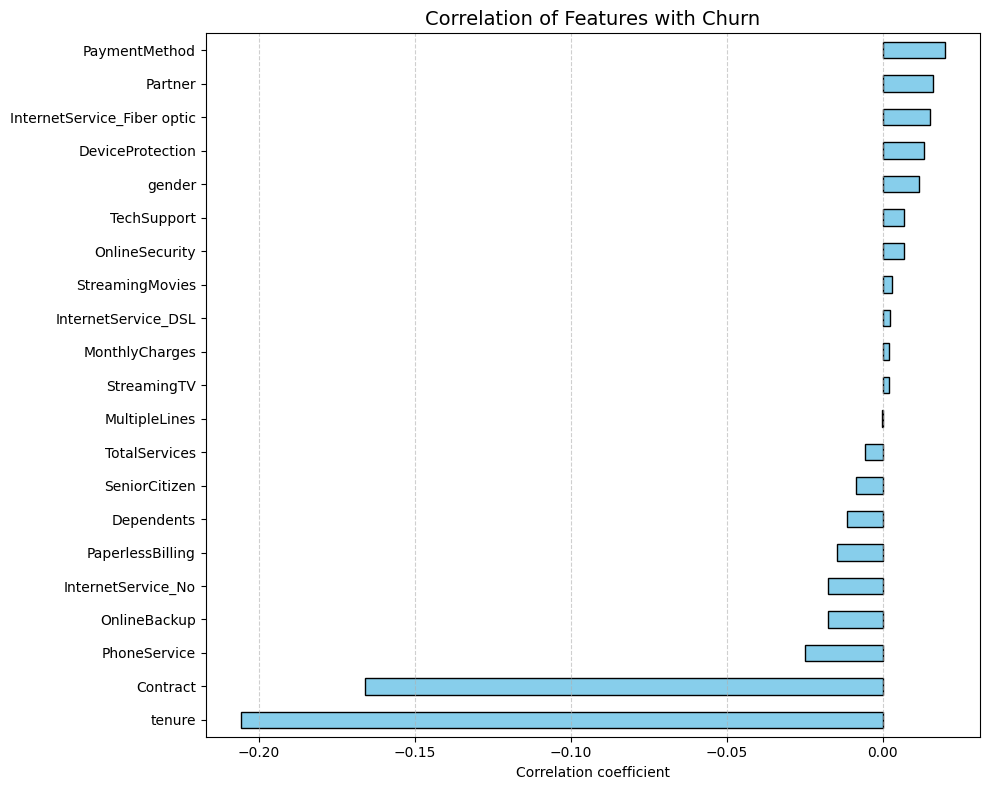

In [63]:
# Compute correlation of all features with 'Churn'
churn_corr = df1.corr()['Churn'].drop('Churn')  # exclude self-correlation

# Plot as bar chart
plt.figure(figsize=(10, 8))
churn_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with Churn", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Observations from Churn Correlation Plot
- Tenure has the strongest negative correlation (≈ -0.22) — longer customers stay, less likely they churn.
- Contract type also negatively correlates — longer contracts = lower churn.
- PhoneService shows slight churn resistance — users with phone service churn a bit less.
- OnlineBackup, TechSupport, and DeviceProtection show weak negative correlation — slight churn protection.
- PaymentMethod has a small positive correlation — certain payment types may relate to higher churn.
- Most features have very low correlation (near 0), implying minimal linear impact individually.

### Correlation plot of all features vs MonthlyCharges

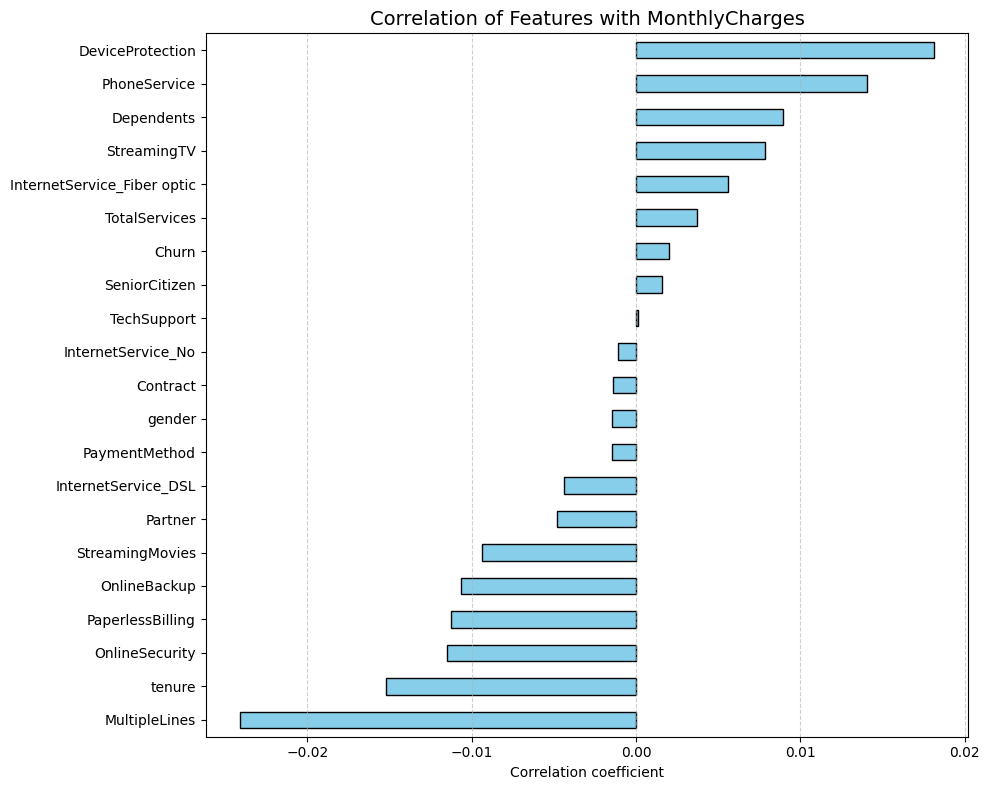

In [64]:
# Compute correlation of all features with 'MonthlyCharges'
monthlycharge_corr = df1.corr()['MonthlyCharges'].drop('MonthlyCharges')  # exclude self-correlation

# Plot as bar chart
plt.figure(figsize=(10, 8))
monthlycharge_corr.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Correlation of Features with MonthlyCharges", fontsize=14)
plt.xlabel("Correlation coefficient")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


##### Observations from MonthlyCharges Correlation Plot
- Customers with DeviceProtection, PhoneService, and StreamingTV tend to pay higher monthly charges.
- Users with Fiber optic internet pay more — confirms it's a premium service.
- Customers with no internet service have lower charges, as expected.
- MultipleLines has a slight negative correlation — possibly due to bundled discounts lowering average cost.

In [65]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       5000 non-null   int64  
 1   SeniorCitizen                5000 non-null   int64  
 2   Partner                      5000 non-null   int64  
 3   Dependents                   5000 non-null   int64  
 4   tenure                       5000 non-null   int64  
 5   PhoneService                 5000 non-null   int64  
 6   MultipleLines                5000 non-null   int64  
 7   OnlineSecurity               5000 non-null   int64  
 8   OnlineBackup                 5000 non-null   int64  
 9   DeviceProtection             5000 non-null   int64  
 10  TechSupport                  5000 non-null   int64  
 11  StreamingTV                  5000 non-null   int64  
 12  StreamingMovies              5000 non-null   int64  
 13  Contract          

### Dropping unncessary columns

In [66]:
unnecessary_cols = ['Partner', 'gender', 'TotalServices']
df1.drop(columns=unnecessary_cols, axis=1, inplace=True)

In [67]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SeniorCitizen                5000 non-null   int64  
 1   Dependents                   5000 non-null   int64  
 2   tenure                       5000 non-null   int64  
 3   PhoneService                 5000 non-null   int64  
 4   MultipleLines                5000 non-null   int64  
 5   OnlineSecurity               5000 non-null   int64  
 6   OnlineBackup                 5000 non-null   int64  
 7   DeviceProtection             5000 non-null   int64  
 8   TechSupport                  5000 non-null   int64  
 9   StreamingTV                  5000 non-null   int64  
 10  StreamingMovies              5000 non-null   int64  
 11  Contract                     5000 non-null   float64
 12  PaperlessBilling             5000 non-null   int64  
 13  PaymentMethod     

## Train-Test-Split

In [68]:
df1['Churn'].value_counts(normalize=True) * 100

Churn
0    73.04
1    26.96
Name: proportion, dtype: float64

**So, data is imbalanced**

### Train-Test-Split for Regression and Classification models

#### Regression

In [69]:
# Separating features and target for Regression
X_reg = df1.drop('MonthlyCharges', axis=1)
y_reg = df1['MonthlyCharges']

# train, test, split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

#### Classification

In [70]:
# Separating features and target for classification
X_cls = df1.drop('Churn', axis=1)
y_cls = df1['Churn']

# train, test, split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

## Handling Imabalnced data

### Handling Imbalance data using SMOTE for classification models

In [71]:
smote = SMOTE(sampling_strategy=0.6, random_state=42)
X_resampled_cls, y_resampled_cls = smote.fit_resample(X_train_cls, y_train_cls)

In [72]:
# Verify class balance
print(y_resampled_cls.value_counts(normalize=True) * 100)

Churn
0    62.502674
1    37.497326
Name: proportion, dtype: float64


## Scaling

In [73]:
df1.head().T

,0,1,2,3,4
SeniorCitizen,0.00,0.00,0.00,0.00,1.00
Dependents,0.00,0.00,0.00,1.00,1.00
tenure,54.00,35.00,36.00,13.00,26.00
PhoneService,0.00,1.00,1.00,0.00,1.00
MultipleLines,1.00,0.00,1.00,1.00,0.00
OnlineSecurity,1.00,1.00,1.00,0.00,0.00
OnlineBackup,2.00,0.00,1.00,2.00,2.00
DeviceProtection,1.00,2.00,1.00,0.00,0.00
TechSupport,2.00,2.00,2.00,0.00,0.00
StreamingTV,1.00,0.00,1.00,1.00,1.00


#### Scaling for regression data

In [74]:
# Features to scale
reg_scale_cols = ['tenure']

scaler_reg = StandardScaler()
# Fit-transform on train, transform on test
X_train_reg_scaled = X_train_reg.copy()
X_test_reg_scaled = X_test_reg.copy()

X_train_reg_scaled[reg_scale_cols] = scaler_reg.fit_transform(X_train_reg[reg_scale_cols])
X_test_reg_scaled[reg_scale_cols] = scaler_reg.transform(X_test_reg[reg_scale_cols])

#### Scaling for classification data

In [75]:
# Features to scale
cls_scale_cols = ['tenure', 'MonthlyCharges']

scaler_cls = StandardScaler()
# Fit-transform on train, transform on test
X_train_cls_scaled = X_train_cls.copy()
X_test_cls_scaled = X_test_cls.copy()

X_train_cls_scaled[cls_scale_cols] = scaler_cls.fit_transform(X_train_cls[cls_scale_cols])
X_test_cls_scaled[cls_scale_cols] = scaler_cls.transform(X_test_cls[cls_scale_cols])


In [79]:
# Compare original and scaled 'tenure' 
pd.concat(
    [X_train_reg[['tenure']].reset_index(drop=True), X_train_reg_scaled[['tenure']].reset_index(drop=True)],axis=1,keys=['Original', 'Scaled']
)

,Original,Scaled
,tenure,tenure
0,72,1.713902
1,14,-1.052591
2,0,-1.720365
3,23,-0.623307
4,6,-1.434176
...,...,...
3995,35,-0.050930
3996,64,1.332316
3997,33,-0.146326


In [ ]:
# Compare original and scaled 'tenure' and 'MonthlyCharges'
pd.concat(
    [X_train_cls[['tenure', 'MonthlyCharges']].reset_index(drop=True), X_train_cls_scaled[['tenure', 'MonthlyCharges']].reset_index(drop=True)],axis=1,keys=['Original', 'Scaled']
)

Original                   Scaled               
       tenure MonthlyCharges    tenure MonthlyCharges
0          51          72.67  0.711335       0.090400
1          16          66.74 -0.953163      -0.122930
2          66          40.02  1.424692      -1.084172
3          37         120.00  0.045536       1.793080
4          33          70.92 -0.144692       0.027444
...       ...            ...       ...            ...
3995       37          70.86  0.045536       0.025286
3996       34          23.13 -0.097135      -1.691784
3997        6          81.84 -1.428734       0.420288
3998       64          96.10  1.329578       0.933286
3999       14          31.86 -1.048277      -1.377726

[4000 rows x 4 columns]